In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tarfile
import scipy.io as sio
import numpy as np
import os
import cv2 as cv
import shutil
import random
from pathlib import Path
import pandas as pd

In [2]:
pwd

'C:\\Users\\Morningstar\\Documents\\CARSv2'

In [3]:
from utils import get_path, get_x, get_y, show_img, draw_outline, draw_rect, draw_text, crop, compare_top_losses, compare_most_confused

In [4]:
path = get_path();path

WindowsPath('C:/Users/Morningstar/Documents/CARSv2')

In [5]:
list(path.iterdir())

[WindowsPath('C:/Users/Morningstar/Documents/CARSv2/.ipynb_checkpoints'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/1-CarsBaseline.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/2-CarsBaseline-ImgScaling.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/3-Cars-ImgScaling-LrRatesTuning.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasic.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-BasicResNet50.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-TRES.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_meta.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos_withlabels.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_trai

In [5]:
cars_test = Path(path/'test')
cars_train = Path(path/'train')

In [6]:
len(list(cars_test.iterdir()))
len(list(cars_train.iterdir()))

8144

# Ucitavanje i kreiranje DataBlock i DataLoaders objekta

In [7]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio
from PIL import Image
import timm
from wwf.vision.timm import *
import torch
import torchvision
import random
from torch.distributions.beta import Beta

In [8]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

Ucitavanje pandas dataframe-ova

In [9]:
labels_df = pd.read_csv(path/'labels_with_annos.csv')
train_labels_df = pd.read_csv(path/'train_labels_with_annos.csv')
test_labels_df = pd.read_csv(path/'test_labels_with_annos.csv')

In [11]:
labels_df.head(10)

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,is_test,filename_cropped,bbox_h,bbox_w
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012,0,cropped_00001.jpg,260,531
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012,0,cropped_00002.jpg,472,833
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007,0,cropped_00003.jpg,273,517
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,0,cropped_00004.jpg,704,864
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,0,cropped_00005.jpg,64,120
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993,0,cropped_00006.jpg,128,257
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012,0,cropped_00007.jpg,318,454
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012,0,cropped_00008.jpg,332,519
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012,0,cropped_00009.jpg,646,1250
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012,0,cropped_00010.jpg,258,603


In [12]:
train_labels_df.head(10)

,filename,class_name,class_id
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106
5,00006.jpg,Geo Metro Convertible 1993,123
6,00007.jpg,Dodge Journey SUV 2012,89
7,00008.jpg,Dodge Charger Sedan 2012,96
8,00009.jpg,Mitsubishi Lancer Sedan 2012,167
9,00010.jpg,Chevrolet Traverse SUV 2012,58


In [13]:
test_labels_df.head(10)

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184
5,test_00006.jpg,Chrysler Town and Country Minivan 2012,78,80
6,test_00007.jpg,GMC Terrain SUV 2012,118,120
7,test_00008.jpg,Mercedes-Benz S-Class Sedan 2012,165,163
8,test_00009.jpg,BMW X5 SUV 2007,32,35
9,test_00010.jpg,Chevrolet HHR SS 2010,60,61


Funkcija za dobavljanje dataloaders objekta na osnovu velicine slike, batch size i seed parametra. 

In [10]:
def get_dls(size,bs,seed):
    random_seed(seed,True)
    augs = [*aug_transforms(size=size, min_scale=0.75),Normalize.from_stats(*imagenet_stats),ToTensor()]
    
    dblock= DataBlock((ImageBlock, CategoryBlock),
                  splitter=RandomSplitter(seed=seed),
                  get_x=get_x, 
                  get_y=get_y,
                  item_tfms=[Resize(460, method='squish'),ToTensor()],
                  batch_tfms=augs)
    dls = dblock.dataloaders(train_labels_df, bs=bs, num_workers=0)
    return dls

# Stage 1 Size 192x192px

U ovoj varijanti ce biti prikazana progresivnog mjenjanja dimenzija slika, gdje krecemo sa slikama manjih dimenzija i zatim povecavamo dimenziju u slijedecim fazama treninga.

Uz to koristeci Learning Rate Finder cemo licno podesavati rate ucenja.

Sada mozemo vidjeti kako izgledaju podatci u nasem DataLoader-u tako sto ucitamo jedan batch.

In [11]:
size = 192
bs = 96
seed = 42
dls = get_dls(size, bs, seed)

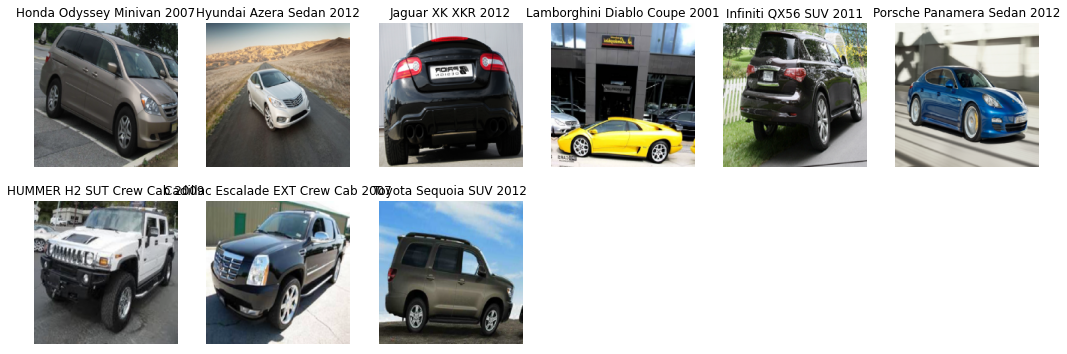

In [16]:
dls.show_batch(nrows=2, ncols=6)

## Kreiranje modela

Kreiramo model koristeci ResNet50 arhitekturu sa defaultnim hiperparametrima.
To podrazumijeva loss funkciju Cross Entropy Loss sa softmax aktivacijom.
Kao optimizator se koristi Adam.
Kao metrika po kojoj cemo pratiti trening koristimo preciznost(accuracy).

Kao callback za regularizaciju cemo ukljuciti MixUp koji miješa vise slika i labela u jednu.
Dio to_fp16() definira mixed precision trening koji ubrzava trening na određenim grafickim karticama kao sto je moja RTX 2060 Super.

In [15]:
mixup = MixUp()
learn = cnn_learner(dls, resnet50, metrics=accuracy, cbs=mixup).to_fp16()

Nakon kreiranja modela mozemo krenuti sa treningom.

## Treniranje modela

Za treniranje ovaj put necemo koristiti fine_tune nego fit_one_cycle metodu koja koristi diskriminativne rate ucenja da bi model bolje generalizirao i ucio. Također, rucno cemo podesavati ratu ucenja kroz lr_find() metodu i zamrzavati i odmrzavati ostale slojeve modela.

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.010964781977236271)

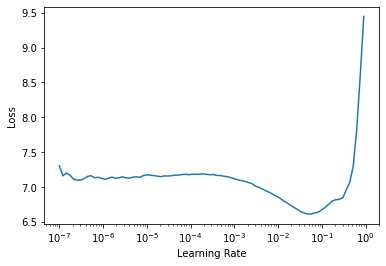

In [13]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(8, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.378321,4.414951,0.113636,04:09
1,5.013480,3.184171,0.253686,04:12
2,4.079893,2.538097,0.365479,04:21
3,3.419476,2.039695,0.476658,04:20
4,3.006478,1.769114,0.540541,04:21
5,2.724425,1.596342,0.584152,04:13
6,2.509581,1.508817,0.616708,04:05
7,2.387236,1.489583,0.620393,04:05


Nakon sto istreniramo gornje slojeve, tj glavu modela onda treniramo citav model tako sto odmrznemo sve slojeve i koristimo diskriminativne rate ucenja.

Diskriminativne rate ucenja osiguravaju da su rate ucenja sporije na nizim slojevima, a brze na visim tj zadnjim slojevima.
To znaci da ce se nizi slojevi manje mijenjati jer su oni vec dobro istrenirani a visi slojevi ce vise trenirati.

In [17]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.918309736647643e-06)

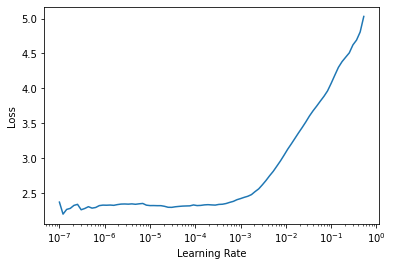

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(12, lr_max= slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.401708,1.482909,0.625307,04:47
1,2.342458,1.446188,0.637592,04:28
2,2.344299,1.401391,0.648649,04:34
3,2.271667,1.359758,0.657862,04:55
4,2.245208,1.330268,0.670762,04:47
5,2.218723,1.303004,0.672604,04:42
6,2.168856,1.272528,0.678747,04:10
7,2.134671,1.264863,0.688575,04:19
8,2.128357,1.252974,0.683661,04:47
9,2.091516,1.249522,0.685504,04:29


Bitno je primjetiti kako je validacijski gubitak uvijek manji od trening gubitka. To je direktan rezultat Mixup regularizacije koja inace najbolje radi ako treniramo dugo vremena, jer ona zapravo sprijecava model da overfit-uje na trening podatcima.

Odnosno zaustavlja model da postane previse dobar u prepoznavanju trening podataka i da se pocne previse prilagođavati trening podatcima. Kao rezultat toga, model ce biti bolji u generalizaciji odnosno bolji u prepoznavanju slika koje nije prije vidio.

In [20]:
learn.save('stage1-resnet50-mixup-192px')

Path('models/stage1-resnet50-mixup-192px.pth')

In [26]:
learn.load('stage1-resnet50-mixup-192px')

# Stage 2 224x224px

Promjena dimenzija na 224x224

In [27]:
size = 224
bs = 64
seed = 42
dls = get_dls(size, bs, seed)

In [28]:
learn.dls = dls

Opet zamrzavamo model da bi trenirali samo glavu modela.

In [29]:
learn.freeze()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=3.311311274956097e-06)

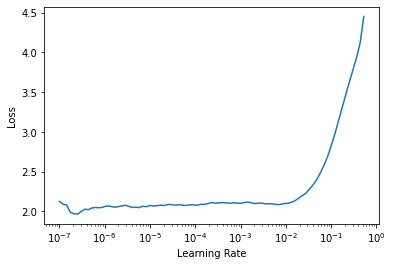

In [24]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,2.074090,1.121872,0.722359,04:10
1,2.028341,1.113366,0.725430,04:06
2,2.044031,1.107814,0.723587,04:06


In [31]:
learn.unfreeze()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=2.75422871709452e-06)

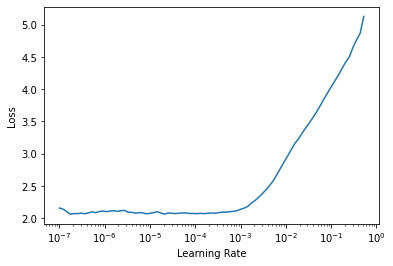

In [32]:
learn.lr_find()

In [35]:
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.041805,1.108306,0.724816,05:07
1,2.025656,1.092307,0.726658,05:15
2,2.008759,1.082659,0.728501,05:05
3,1.988015,1.068035,0.734029,05:05
4,1.972557,1.057298,0.739558,04:39
5,1.945594,1.029362,0.735872,04:39
6,1.885094,1.016862,0.749386,04:49
7,1.861938,1.001107,0.743858,04:41
8,1.882459,0.990984,0.750000,04:24
9,1.873783,0.986858,0.753071,04:22


In [36]:
learn.save('stage2-resnet50-mixup-224px')

Path('models/stage2-resnet50-mixup-224px.pth')

In [37]:
learn.load('stage2-resnet50-mixup-224px')

# Stage 3 299x299px

Promjena dimenzija na 299x299px

In [39]:
size = 299
bs = 48
seed = 42
dls = get_dls(size, bs, seed)

In [40]:
learn.dls = dls

In [41]:
learn.freeze()

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=0.0002290867705596611)

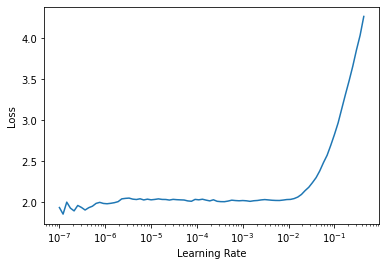

In [42]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.025910,1.002478,0.740172,04:25
1,2.001403,0.916184,0.762899,04:25
2,1.860201,0.896981,0.775184,04:32


In [44]:
learn.unfreeze()

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=2.511886486900039e-05)

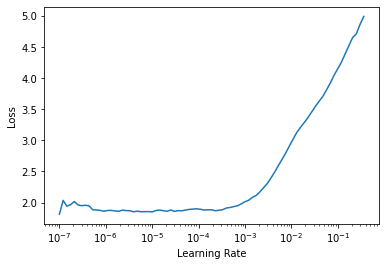

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(20, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.864651,0.889457,0.775184,04:42
1,1.809013,0.866470,0.780713,04:39
2,1.779595,0.851953,0.789312,04:39
3,1.798338,0.847014,0.788084,04:38
4,1.751287,0.820414,0.791769,04:39
5,1.728853,0.790253,0.805897,04:38
6,1.709262,0.771128,0.802211,04:38
7,1.691514,0.756749,0.818796,04:39
8,1.668633,0.750252,0.815111,04:38
9,1.688451,0.743717,0.811425,04:39


In [47]:
learn.save('stage3-resnet50-mixup-299px')

Path('models/stage3-resnet50-mixup-299px.pth')

In [48]:
learn.load('stage3-resnet50-mixup-299px')

# Rezulatati

In [ ]:
compare_top_losses(10, interp, labels_df, 1, path=path)

# Testiranje na testnom setu podataka

Predikcija na samo jednoj slici iz testnog seta

In [52]:
test_labels_df.head()

,filename,class_name,class_id,vocab_id
0,test_00001.jpg,Suzuki Aerio Sedan 2007,181,180
1,test_00002.jpg,Ferrari 458 Italia Convertible 2012,103,100
2,test_00003.jpg,Jeep Patriot SUV 2012,145,147
3,test_00004.jpg,Toyota Camry Sedan 2012,187,186
4,test_00005.jpg,Tesla Model S Sedan 2012,185,184


In [53]:
test_item = path/'merged'/test_labels_df['filename'][0]; test_item

Path('C:/Users/Morningstar/Documents/CARSv2/merged/test_00001.jpg')

In [54]:
pred_y,pred_idx,probs=learn.predict(test_item)

In [55]:
act_y_id = test_labels_df['vocab_id'][0]
act_y = test_labels_df['class_name'][0]

In [62]:
np.argmax(probs)

tensor(180)

In [56]:
pred_y,act_y

("['Volvo XC90 SUV 2007', 'Acura Integra Type R 2001', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'Acura TL Sedan 2012', 'Acura Integra Type R 2001', 'Volvo XC90 SUV 2007', 'Volvo XC90 SUV 2007', 'Acura Integra Type R 2001', 'Volvo C30 Hatchback 2012', 'smart fortwo Convertible 2012', 'Acura Integra Type R 2001', 'smart fortwo Convertible 2012', 'Acura RL Sedan 2012', 'AM General Hummer SUV 2000', 'Volvo C30 Hatchback 2012', 'smart fortwo Convertible 2012', 'Acura Integra Type R 2001', 'Volvo C30 Hatchback 2012', 'AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'AM General Hummer SUV 2000', 'AM General Hummer SUV 2000', 'smart fortwo Convertible 2012', 'Volvo XC90 SUV 2007', 'AM General Hummer SUV 2000', 'Acura TL Sedan 2012', 'AM General Hummer SUV 2000', 'Volvo XC90 SUV 2007', 'smart fortwo Convertible 2012', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'AM General Hummer SUV 2000', 'Volvo C30 Hatchback 2012', 'Volvo XC90 SUV 2007', 'Volvo XC90 SUV 2007', '

In [58]:
np.argmax(pred_idx),act_y_id

(tensor(180), 180)

Ucitavanje testnih itema na isti nacin kao sto smo ucitavali trening iteme kroz get_x funkciju

In [63]:
test_items = get_x(test_labels_df);test_items

0       C:\Users\Morningstar\Documents\CARSv2\merged\test_00001.jpg
1       C:\Users\Morningstar\Documents\CARSv2\merged\test_00002.jpg
2       C:\Users\Morningstar\Documents\CARSv2\merged\test_00003.jpg
3       C:\Users\Morningstar\Documents\CARSv2\merged\test_00004.jpg
4       C:\Users\Morningstar\Documents\CARSv2\merged\test_00005.jpg
                                   ...                             
8036    C:\Users\Morningstar\Documents\CARSv2\merged\test_08037.jpg
8037    C:\Users\Morningstar\Documents\CARSv2\merged\test_08038.jpg
8038    C:\Users\Morningstar\Documents\CARSv2\merged\test_08039.jpg
8039    C:\Users\Morningstar\Documents\CARSv2\merged\test_08040.jpg
8040    C:\Users\Morningstar\Documents\CARSv2\merged\test_08041.jpg
Name: filename, Length: 8041, dtype: object

Kreiranje test dataloader objekta koji ce sadrzavati sve test iteme

In [64]:
test_dl = learn.dls.test_dl(test_items)

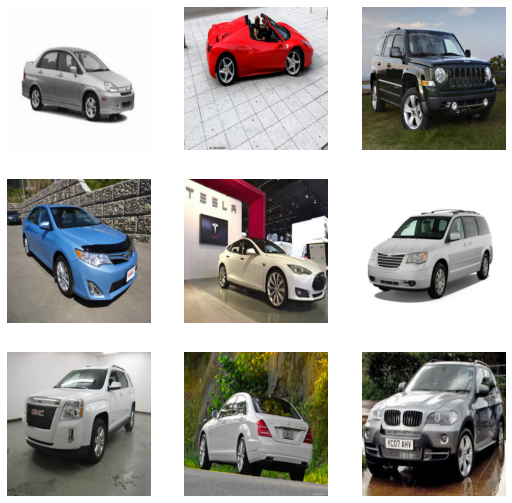

In [65]:
test_dl.show_batch()

Predikcije nad citavim test setom

In [66]:
preds = learn.get_preds(dl=test_dl)

Da bi provjerili tacnost na citavom datasetu prvo trebamo spasiti sve predikcije u jednu varijablu.

Mozemo primjetiti oblik tensora za predikcije, koji je broj slika (8041) sa broj klasa (196), jer za svaku sliku sadrzava 196 vrijednosti koje izgledaju isto kao sto smo vidjeli iznad.

In [67]:
a = preds[0]; a.shape

torch.Size([8041, 196])

Zatim nam treba varijabla, tj tensor s kojim cemo porediti ove predikcije, odnosno onaj koji sadrzava stvarne vrijednosti klasa za slike iz test seta.

Za te potrebe kreirat cemo numpy array koji cemo poslije pretvoriti u PyTorch tensor.

In [68]:
b = np.array(test_labels_df['vocab_id'],dtype=np.int)
b = torch.from_numpy(b);b.shape

torch.Size([8041])

Sve sto nam preostaje je da pozovemo accuracy funkciju koja ce za nas na proslijedenom tensoru a uraditi argmax funkciju i porediti sa proslijedenim tensorom b

In [69]:
accuracy(a,b)

tensor(0.8348)

Tacnost ovog modela na testnom setu podataka je 83.48% sto je losije od prijasnje varijacije zbog toga sto Mixup zahtjeva puno vise treninga za bolju regularizaciju i zato sto bi trebali promijeniti funkciju gubitka na label smoothing koji puno bolje radi sa Mixup varijantom. Također cesto pomaze i koristiti drugi optimizator sto cemo vidjeti u slijedecim varijacijama.

Jedna stvar koja je bitna za primjetiti je da je validacijski gubitak (val. loss) manji od trening gubitka (train. loss), sto je direktan rezultat regularizacije koja je sprijecila model da overfittuje na trening set.